
--- CUSTOMER SEGMENT INSIGHTS ---

Cluster 0 – Potential Upsell Customers
 Customers: 38
 Avg Age: 40.4
 Avg Income: 87.0k
 Avg Spending Score: 18.6

Cluster 1 – Budget Customers
 Customers: 69
 Avg Age: 52.1
 Avg Income: 46.4k
 Avg Spending Score: 39.9

Cluster 2 – Premium Customers
 Customers: 39
 Avg Age: 32.7
 Avg Income: 86.5k
 Avg Spending Score: 82.1

Cluster 3 – Budget Customers
 Customers: 54
 Avg Age: 25.3
 Avg Income: 41.3k
 Avg Spending Score: 62.5


--- MODEL COMPARISON ---
Standard K-means SSE: 205.23
Hybrid K-means SSE: 212.21


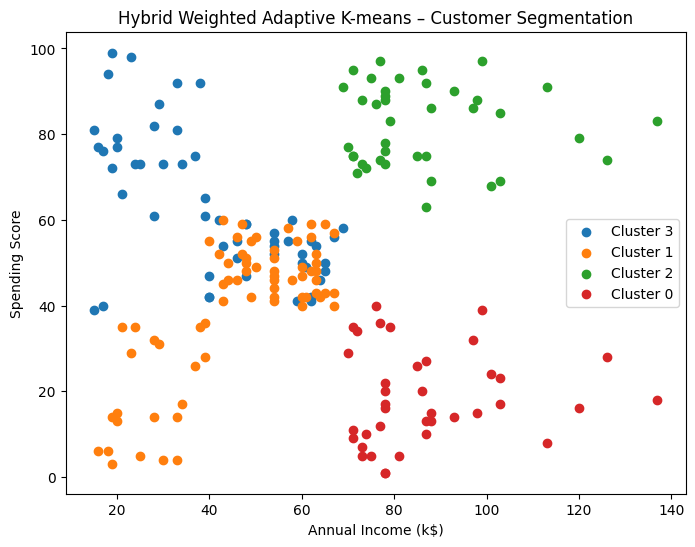

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

df = pd.read_csv("Mall_Customers.csv")

features = df[["Age", "Annual Income (k$)", "Spending Score (1-100)"]].values

mean = features.mean(axis=0)
std = features.std(axis=0)
X = (features - mean) / std

weights = np.array([0.2, 0.3, 0.5])

def weighted_distance(a, b, w):
    return np.sqrt(np.sum(w * (a - b) ** 2))

def initialize_centroids(X, K):
    idx = np.random.choice(len(X), K, replace=False)
    return X[idx]

def assign_clusters(X, centroids, w):
    clusters = [[] for _ in centroids]
    for i, x in enumerate(X):
        distances = [weighted_distance(x, c, w) for c in centroids]
        clusters[np.argmin(distances)].append(i)
    return clusters

def update_centroids(X, clusters):
    return np.array([X[c].mean(axis=0) for c in clusters if len(c) > 0])

def merge_centroids(centroids, w, alpha=0.7):
    merged = []
    used = set()

    dists = [
        weighted_distance(centroids[i], centroids[j], w)
        for i in range(len(centroids))
        for j in range(i + 1, len(centroids))
    ]

    if not dists:
        return centroids, False

    threshold = alpha * np.mean(dists)

    for i in range(len(centroids)):
        if i in used:
            continue
        current = centroids[i]
        for j in range(i + 1, len(centroids)):
            if j not in used and weighted_distance(current, centroids[j], w) < threshold:
                current = (current + centroids[j]) / 2
                used.add(j)
        merged.append(current)
        used.add(i)

    return np.array(merged), len(merged) < len(centroids)

def hybrid_kmeans(X, K_init, w, max_iter=100):
    centroids = initialize_centroids(X, K_init)

    for _ in range(max_iter):
        clusters = assign_clusters(X, centroids, w)
        new_centroids = update_centroids(X, clusters)
        merged_centroids, merged = merge_centroids(new_centroids, w)

        if not merged and np.allclose(centroids, merged_centroids):
            break+

        centroids = merged_centroids

    final_clusters = assign_clusters(X, centroids, w)
    return centroids, final_clusters

INITIAL_K = 8
centroids, clusters = hybrid_kmeans(X, INITIAL_K, weights)

labels = np.zeros(len(X))
for i, c in enumerate(clusters):
    for idx in c:
        labels[idx] = i

df["Cluster"] = labels.astype(int)

def label_segment(income, spending):
    if income > 70 and spending > 70:
        return "Premium Customers"
    if income > 70 and spending < 40:
        return "Potential Upsell Customers"
    if income < 40 and spending > 60:
        return "Young Impulsive Shoppers"
    return "Budget Customers"

print("\n--- CUSTOMER SEGMENT INSIGHTS ---\n")

cluster_summary = []

for cluster_id in sorted(df["Cluster"].unique()):
    cluster_data = df[df["Cluster"] == cluster_id]

    avg_age = cluster_data["Age"].mean()
    avg_income = cluster_data["Annual Income (k$)"].mean()
    avg_spending = cluster_data["Spending Score (1-100)"].mean()
    count = len(cluster_data)

    segment = label_segment(avg_income, avg_spending)

    print(f"Cluster {cluster_id} – {segment}")
    print(f" Customers: {count}")
    print(f" Avg Age: {avg_age:.1f}")
    print(f" Avg Income: {avg_income:.1f}k")
    print(f" Avg Spending Score: {avg_spending:.1f}\n")

    cluster_summary.append([
        cluster_id, segment, count,
        avg_age, avg_income, avg_spending
    ])

summary_df = pd.DataFrame(
    cluster_summary,
    columns=["Cluster", "Segment", "Count", "Avg Age", "Avg Income", "Avg Spending"]
)

summary_df.to_csv("cluster_summary.csv", index=False)

kmeans = KMeans(n_clusters=len(centroids), random_state=42)
kmeans.fit(X)

print("\n--- MODEL COMPARISON ---")
print(f"Standard K-means SSE: {kmeans.inertia_:.2f}")

hybrid_sse = 0
for i, cluster in enumerate(clusters):
    for idx in cluster:
        hybrid_sse += np.sum((X[idx] - centroids[i]) ** 2)

print(f"Hybrid K-means SSE: {hybrid_sse:.2f}")

plt.figure(figsize=(8, 6))
for cid in df["Cluster"].unique():
    plt.scatter(
        df[df["Cluster"] == cid]["Annual Income (k$)"],
        df[df["Cluster"] == cid]["Spending Score (1-100)"],
        label=f"Cluster {cid}"
    )

plt.xlabel("Annual Income (k$)")
plt.ylabel("Spending Score")
plt.title("Hybrid Weighted Adaptive K-means – Customer Segmentation")
plt.legend()
plt.show()


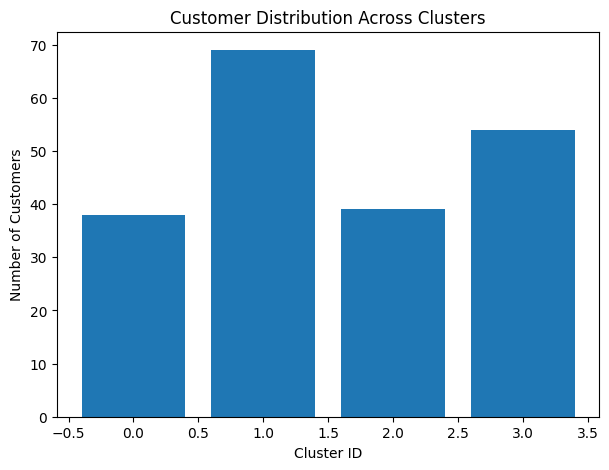

In [ ]:
import matplotlib.pyplot as plt

cluster_counts = df["Cluster"].value_counts().sort_index()

plt.figure(figsize=(7,5))
plt.bar(cluster_counts.index, cluster_counts.values)
plt.xlabel("Cluster ID")
plt.ylabel("Number of Customers")
plt.title("Customer Distribution Across Clusters")
plt.show()


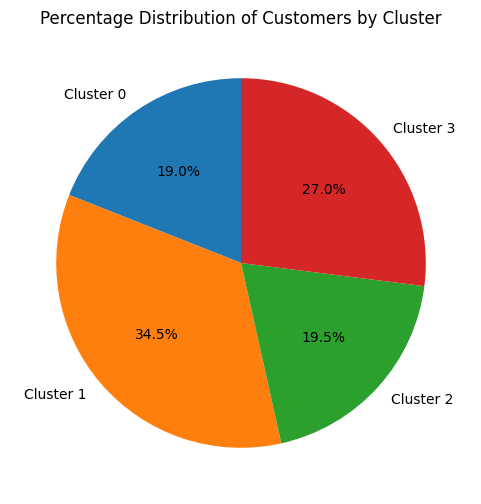

In [ ]:
plt.figure(figsize=(6,6))
plt.pie(
    cluster_counts.values,
    labels=[f"Cluster {i}" for i in cluster_counts.index],
    autopct="%1.1f%%",
    startangle=90
)
plt.title("Percentage Distribution of Customers by Cluster")
plt.show()


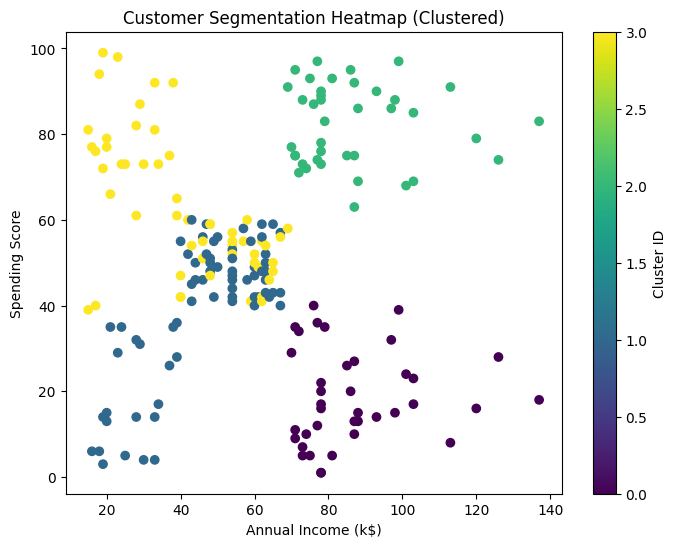

In [ ]:
plt.figure(figsize=(8,6))
plt.scatter(
    df["Annual Income (k$)"],
    df["Spending Score (1-100)"],
    c=df["Cluster"],
    cmap="viridis"
)
plt.xlabel("Annual Income (k$)")
plt.ylabel("Spending Score")
plt.title("Customer Segmentation Heatmap (Clustered)")
plt.colorbar(label="Cluster ID")
plt.show()
